# Clustering Case Study: Customer Segmentation with K-Means - Tier 3

---

This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**

   - Load the data
   - Explore the data

2. **Cleaning, transforming and visualizing**

   - Data Wrangling: Exercise Set 1
     - Creating a matrix with a binary indicator for whether they responded to a given offer
     - Ensure that in doing so, NAN values are dealt with appropriately

3. **Modelling**

   - K-Means clustering: Exercise Sets 2 and 3

     - Choosing K: The Elbow method
     - Choosing K: The Silhouette method
     - Choosing K: The Gap statistic method

   - Visualizing clusters with PCA: Exercise Sets 4 and 5

4. **Conclusions and next steps**
   - Conclusions
   - Other clustering algorithms (Exercise Set 6)


In [1]:
# %matplotlib inline
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
# sns.set_context("poster")
sns.set_context("talk")

## 1. Sourcing and loading

### 1a. Load the data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.


In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

b:\project\Springboard\Springboard\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,discount_bin,min_qty_bin
0,1,January,Malbec,72,56,France,False,medium,medium
1,2,January,Pinot Noir,72,17,France,False,low,medium
2,3,February,Espumante,144,32,Oregon,True,low,high
3,4,February,Champagne,72,48,France,True,medium,medium
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True,low,high


Descriptive statistics:


,count,unique,top,freq
campaign,32,12,February,3
varietal,32,9,Champagne,7
origin,32,9,France,9


,count,mean,std,min,25%,50%,75%,max
offer_id,32.0,16.50000,9.380832,1.0,8.75,16.5,24.25,32.0
min_qty,32.0,65.81250,50.785722,6.0,12.00,72.0,72.00,144.0
discount,32.0,57.84375,20.770807,17.0,44.75,55.0,82.25,89.0


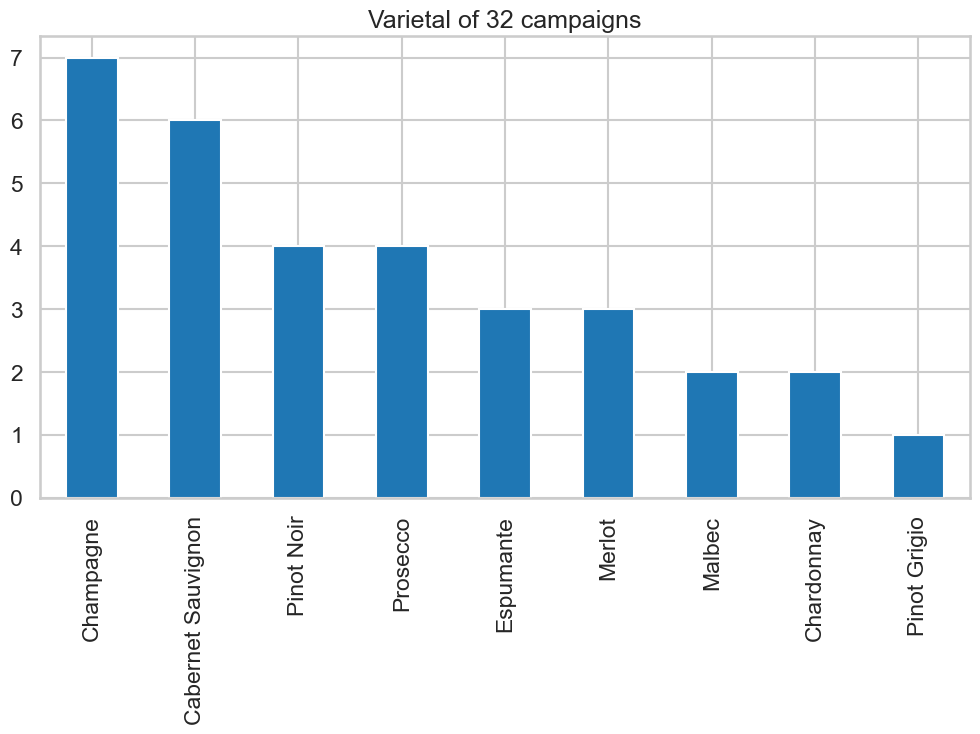

In [3]:
df_offers.columns = [
    "offer_id",
    "campaign",
    "varietal",
    "min_qty",
    "discount",
    "origin",
    "past_peak",
]
df_offers["discount_bin"] = pd.qcut(
    df_offers["discount"], q=3, labels=["low", "medium", "high"]
)
df_offers["min_qty_bin"] = pd.qcut(
    df_offers["min_qty"], q=3, labels=["low", "medium", "high"]
)

display(df_offers.head())
print("Descriptive statistics:")
display(df_offers.describe(include="O").T)
display(df_offers.describe().T)

df_offers.varietal.value_counts().plot(
    kind="bar", figsize=(12, 6), title="Varietal of 32 campaigns"
)
plt.show()

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.


In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions["n"] = 1
# df_transactions.offer_id = df_transactions.offer_id.astype('str')
print(df_transactions.head())
df_transactions.describe(include="O").T

  customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1


b:\project\Springboard\Springboard\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,count,unique,top,freq
customer_name,324,100,Sanders,9


## 2. Cleaning, transforming and visualizing

### 2a. Data Wrangling


We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer.


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>


In [5]:
# your turn
merged = pd.merge(df_transactions, df_offers, on="offer_id")

display(merged)

customer_offer_df = pd.pivot_table(
    df_transactions,
    columns=["offer_id"],
    index=["customer_name"],
    values="n",
    fill_value=0,
)
customer_offer_df

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,discount_bin,min_qty_bin
0,Smith,2,1,January,Pinot Noir,72,17,France,False,low,medium
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False,low,medium
2,Martin,2,1,January,Pinot Noir,72,17,France,False,low,medium
3,Jackson,2,1,January,Pinot Noir,72,17,France,False,low,medium
4,Campbell,2,1,January,Pinot Noir,72,17,France,False,low,medium
...,...,...,...,...,...,...,...,...,...,...,...
319,Hill,13,1,May,Merlot,6,43,Chile,False,low,low
320,Carter,13,1,May,Merlot,6,43,Chile,False,low,low
321,James,13,1,May,Merlot,6,43,Chile,False,low,low
322,Hughes,13,1,May,Merlot,6,43,Chile,False,low,low


offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling

### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to _maximize_ the distance between centroids and _minimize_ the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.


#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned.

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the _elbow point_ in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly.

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture.


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>


k: 2, Inertia: 252.11466260781333
k: 3, Inertia: 230.27634521313766
k: 4, Inertia: 214.78588258975083
k: 5, Inertia: 205.45535714285714
k: 6, Inertia: 197.79085497835501
k: 7, Inertia: 188.78220668220672
k: 8, Inertia: 186.18182677537516
k: 9, Inertia: 176.6684981684982
k: 10, Inertia: 171.91968864468865


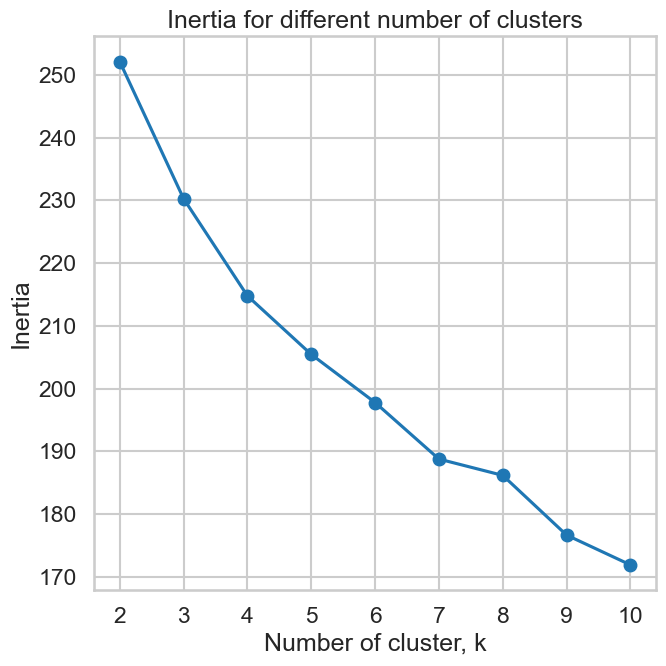

In [6]:
# your turn


x_cols = customer_offer_df.to_numpy()
inertias = []
ks = range(2, 11)


for k in ks:
    kmeans = KMeans(n_init="auto", n_clusters=k, random_state=628)
    kmeans.fit_predict(x_cols)
    print(f"k: {k}, Inertia: {kmeans.inertia_}")

    inertias.append(kmeans.inertia_)


# plot inertia vs k

plt.figure(figsize=(7, 7))
plt.plot(ks, inertias, "-o")
plt.xticks(ks)
plt.xlabel("Number of cluster, k")
plt.ylabel("Inertia")
plt.title("Inertia for different number of clusters")
plt.tight_layout()
plt.show()

Bin counts:
0    23
1    16
2    27
3    34
dtype: int64


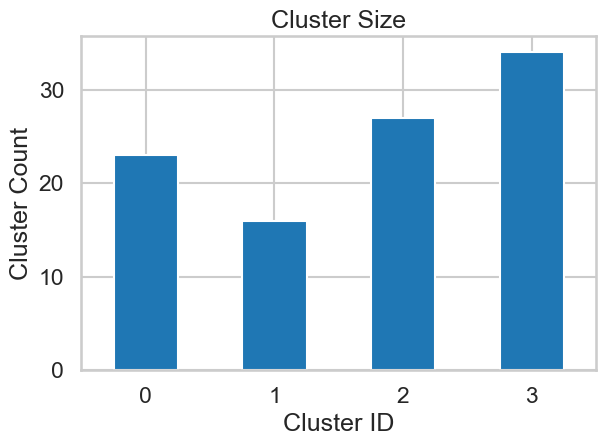

In [7]:
best_k = 4


kmeans = KMeans(n_init="auto", n_clusters=best_k, random_state=628)
kmeans.fit_predict(x_cols)
print("Bin counts:")
print(pd.Series(kmeans.labels_).value_counts().sort_index())
pd.Series(kmeans.labels_).value_counts().sort_index().plot(
    kind="bar", rot=0, title="Cluster Size"
)
plt.ylabel("Cluster Count")
plt.xlabel("Cluster ID")
plt.tight_layout()
plt.show()

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster _and also_ how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the _average_ distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on _every datapoint in every cluster_. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.


<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>

Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html


**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>


For n_clusters = 2, the average silhouette_score is : 0.08092562176701561
For n_clusters = 3, the average silhouette_score is : 0.11806651945633657
For n_clusters = 4, the average silhouette_score is : 0.13260553342996584
For n_clusters = 5, the average silhouette_score is : 0.13783358261902107
For n_clusters = 6, the average silhouette_score is : 0.12920782569458733
For n_clusters = 7, the average silhouette_score is : 0.128752966230583
For n_clusters = 8, the average silhouette_score is : 0.12378349038478592
For n_clusters = 9, the average silhouette_score is : 0.1203258674118111
For n_clusters = 10, the average silhouette_score is : 0.1029783166144777


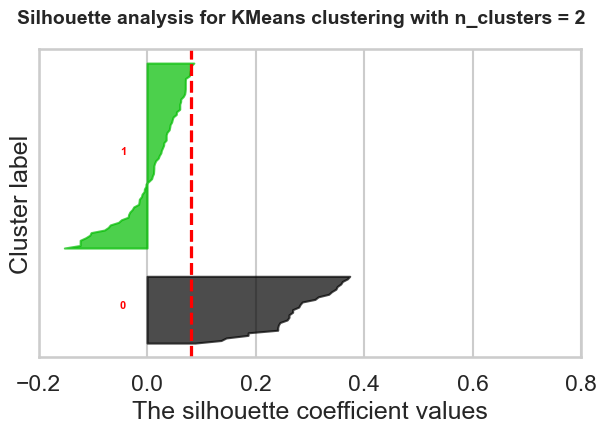

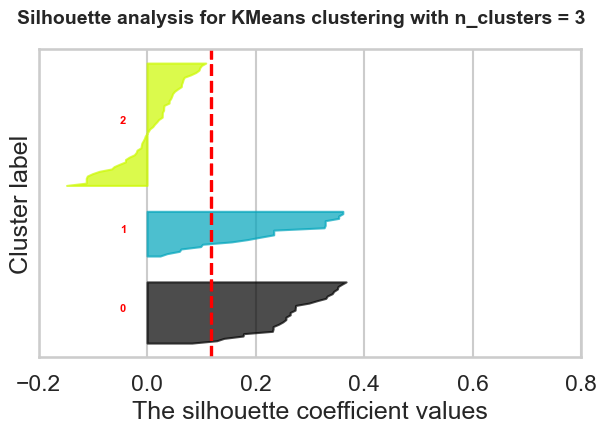

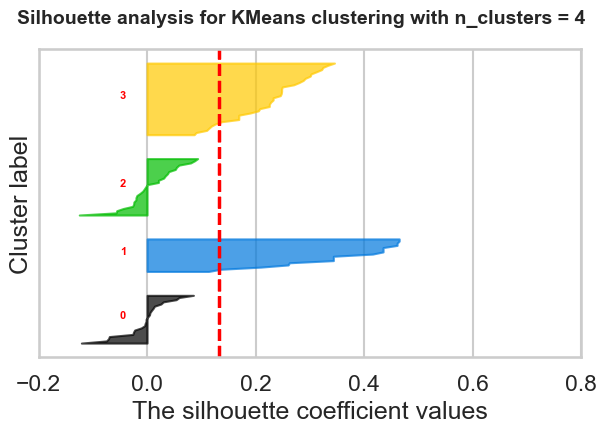

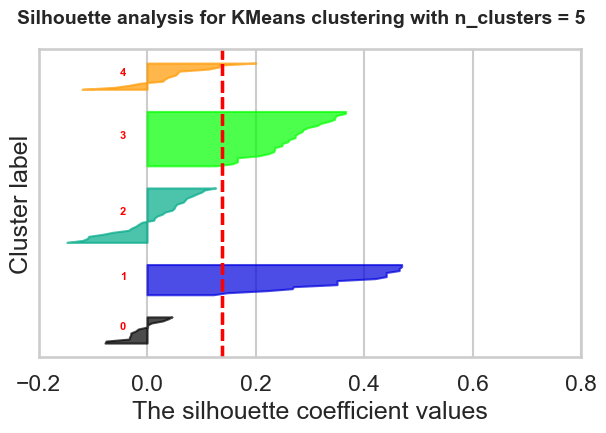

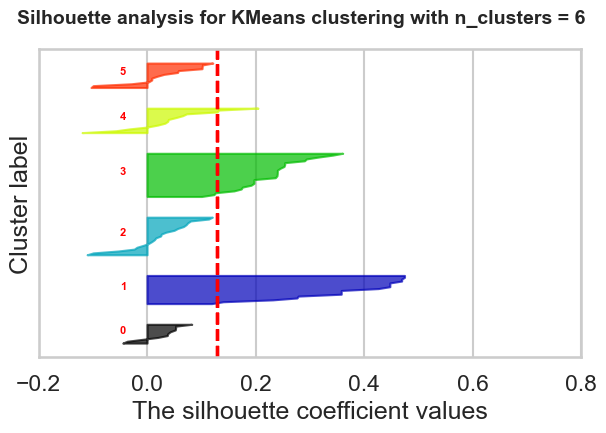

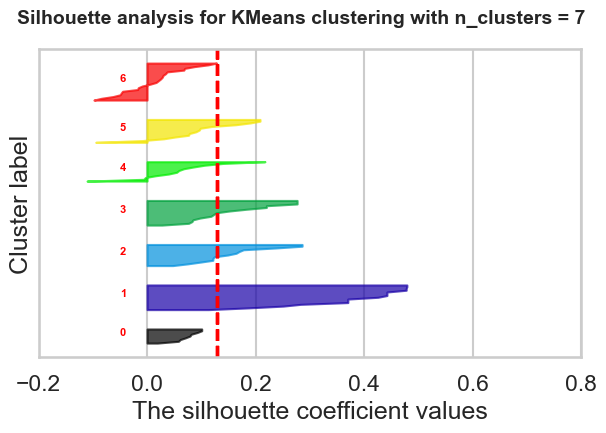

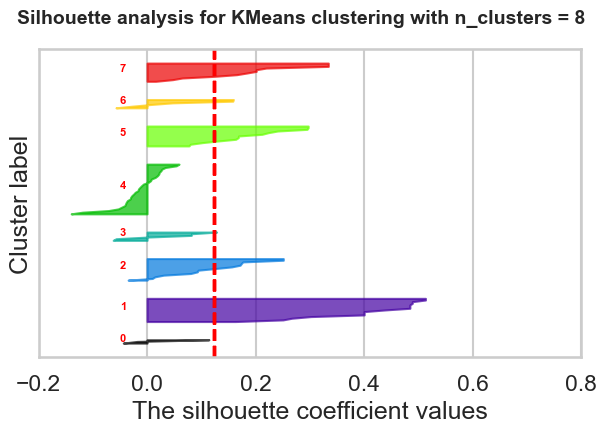

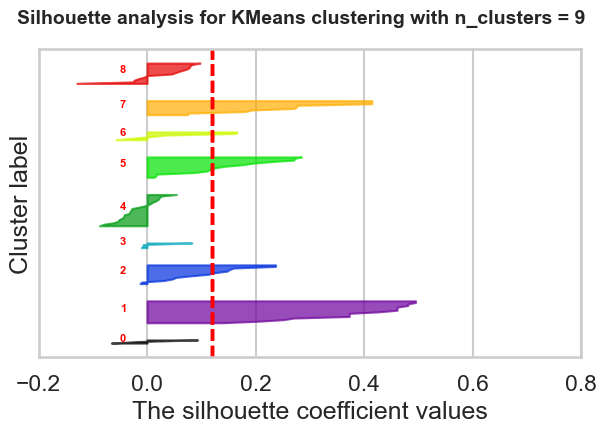

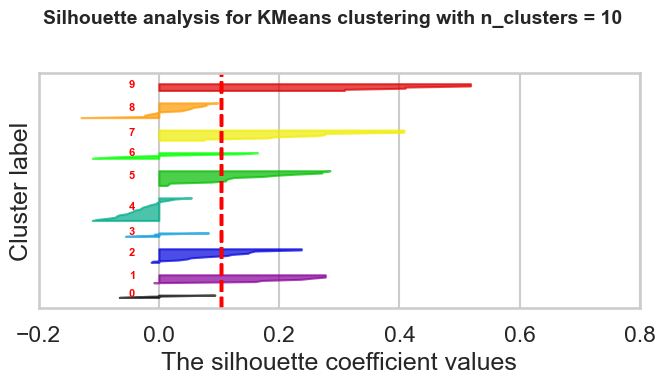

In [8]:
# Your turn.
avg_silhouette_scores = []

for k in ks:
    fig, ax = plt.subplots(figsize=(7, 4))

    clusterer = KMeans(n_init="auto", n_clusters=k, random_state=628)
    cluster_labels = clusterer.fit_predict(x_cols)

    # computed silhouette avg
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")
    avg_silhouette_scores.append(silhouette_avg)

    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax.text(
            -0.05,
            y_lower + 0.5 * size_cluster_i,
            str(i),
            color="red",
            fontweight="bold",
            fontsize=8,
        )

        y_lower = y_upper + 10

        # ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # line for avg silhouette score
        ax.axvline(
            x=silhouette_avg, color="red", linestyle="--", label="avg silhouette score"
        )
        ax.set_yticks([])
        ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering with n_clusters = {k}",
            fontsize=14,
            fontweight="bold",
        )

plt.tight_layout()
plt.show()

In [9]:
high_index = avg_silhouette_scores.index(max(avg_silhouette_scores))

high_point = ks[high_index], avg_silhouette_scores[high_index]

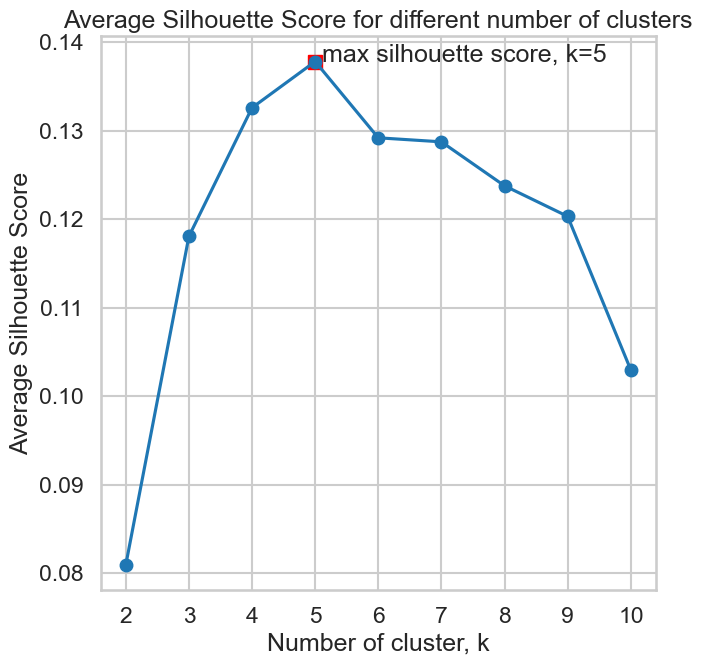

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
# highest silhouette score
plt.plot(high_point[0], high_point[1], "s", markersize=10, color="red")
# labelled on plot
ax.annotate(
    f"max silhouette score, k={ks[high_index]}",
    xy=high_point,
    xytext=(high_point[0] + 0.1, high_point[1] - 0.05),
    textcoords="offset points",
)

plt.plot(ks, avg_silhouette_scores, "-o")
plt.xticks(ks)
plt.xlabel("Number of cluster, k")
plt.ylabel("Average Silhouette Score")
plt.title("Average Silhouette Score for different number of clusters")
plt.tight_layout()
plt.show()

The plots suggest that we choose a k of 5. Yes, it is different from the elbow method, which suggested a k of 4.


#### 3aiii. Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.


#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

- Adjusted Rand Index
- Mutual Information
- V-Measure
- Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.


### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/).


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>


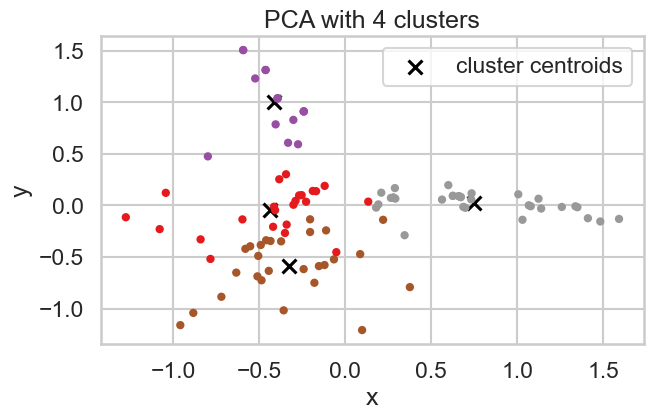

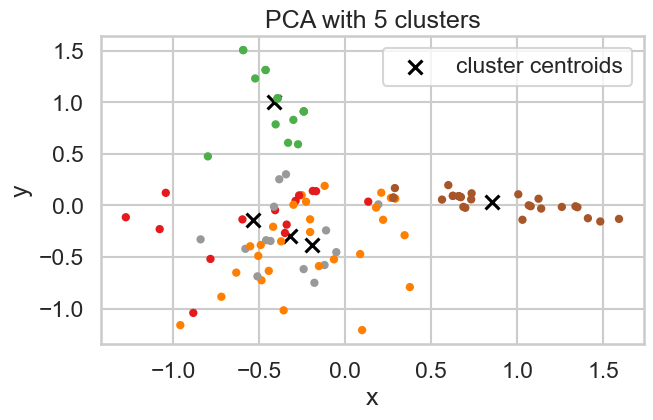

In [11]:
# your turn


def plot_pca_2d(n_clusters):
    """Plot 2D PCA with cluster centroids"""
    kmeans = KMeans(n_init="auto", n_clusters=n_clusters, random_state=628)
    kmeans.fit_predict(x_cols)
    # print(kmeans.cluster_centers_)

    pca = PCA(n_components=2, random_state=628)
    pca.fit(x_cols)
    pca_centers = pca.transform(kmeans.cluster_centers_)

    # DataFrame with customer name, custer label, and x, y columns
    pca_df = pd.DataFrame(pca.transform(x_cols), columns=["x", "y"])
    pca_df["customer_name"] = customer_offer_df.index
    pca_df["cluster"] = kmeans.labels_

    fig, ax = plt.subplots(figsize=(7, 4))

    # plotted cluster centroids
    ax.scatter(
        pca_centers[:, 0],
        pca_centers[:, 1],
        marker="x",
        s=100,
        c="black",
        label="cluster centroids",
    )

    # plotted customers by cluster
    pca_df.plot(
        kind="scatter",
        x="x",
        y="y",
        figsize=(7, 4),
        title="PCA",
        c=kmeans.labels_,
        cmap="Set1",
        colorbar=False,
        ax=ax,
    )
    plt.title(f"PCA with {n_clusters} clusters")
    plt.legend()
    plt.show()
    return pca_df


pca_df_4 = plot_pca_2d(n_clusters=4)
pca_df_5 = plot_pca_2d(n_clusters=5)

4 clusters seemed to have less overlap than 5 clusters. The elbow method seems to have produced the optimal result visually.


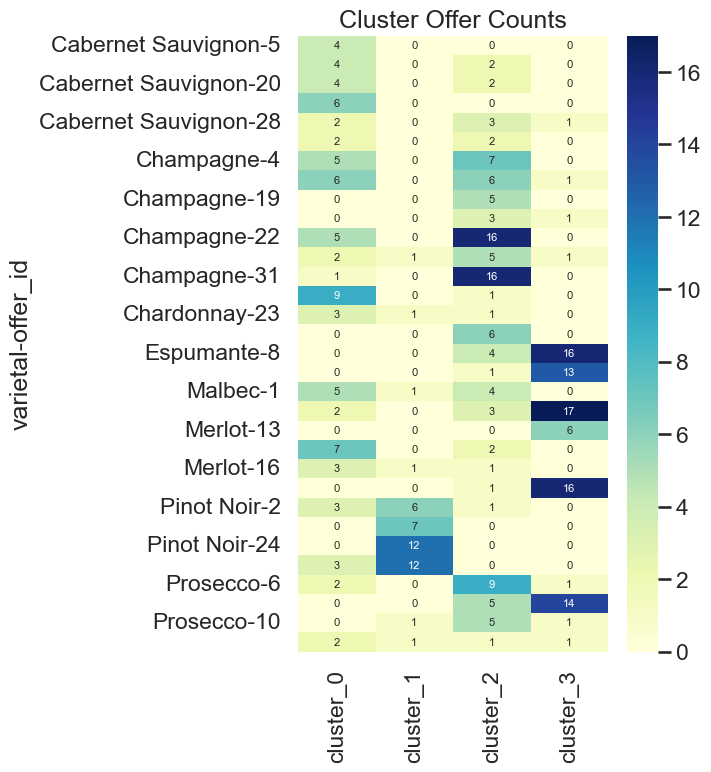

In [12]:
n_clusters = 4
pca_df = pca_df_4
cluster_cols = [f"cluster_{i}" for i in range(n_clusters)]


def get_cluster_offer_id_sum(df, cluster_id):
    """Get sum of each offer ids for a cluster"""

    # Got cluster customers
    cluster_customers = df[df["cluster"] == cluster_id].index
    # Got sum of each offer ids for cluster customers
    cluster_offer_ids_sum = customer_offer_df.iloc[cluster_customers].sum()
    return cluster_offer_ids_sum.to_frame().rename(columns={0: f"cluster_{cluster_id}"})


def plot_heatmap(df, size=(5, 5), title=None):
    """Plot heatmap of cluster offer counts"""
    fig = plt.figure(figsize=size)
    sns.heatmap(
        df[cluster_cols],
        annot=True,
        annot_kws={"fontsize": 8},
        cmap="YlGnBu",
    )
    # rotate y labels
    plt.yticks(rotation=0)
    if title:
        plt.title(title)


# Initiate empty DataFrame with offer ids as index
cluster_offer_df = pd.DataFrame(index=df_offers["offer_id"])

# joined summed offer ids for each cluster
for i in range(n_clusters):
    cluster_offer_df = cluster_offer_df.join(get_cluster_offer_id_sum(pca_df, i))

# merged in varietal and offer_id columns
cluster_offer_df = cluster_offer_df.merge(
    df_offers[["offer_id", "varietal"]], on="offer_id"
)
cluster_offer_df.set_index(["varietal", "offer_id"], inplace=True)


plot_heatmap(cluster_offer_df.sort_index(), size=(5, 8), title="Cluster Offer Counts")
plt.show()

On observing the clusters in context with the original data, we can see that the clusters correspond to wine variants.
For example,

- `cluster_1` seems to be associated with Pinot Noir,
- `cluster_2` with Champagne, and
- `cluster_3` with Espumante.

Additionally, `cluster_3` seemed to be associated with low minimum quantity.
This is interesting because it shows that the clustering algorithm was able to identify this pattern without being told to do so. This is a good sign that the algorithm is working well.


,varietal,offer_id,cluster_0,cluster_1,cluster_2,cluster_3,min_qty_bin,discount_bin,origin
6,Prosecco,7,0,0,5,14,low,low,Australia
7,Espumante,8,0,0,4,16,low,low,South Africa
12,Merlot,13,0,0,0,6,low,low,Chile
16,Pinot Noir,17,0,7,0,0,low,low,Germany
23,Pinot Noir,24,0,12,0,0,low,low,Italy
17,Espumante,18,0,0,1,13,low,medium,Oregon
20,Champagne,21,0,0,3,1,low,medium,California
27,Cabernet Sauvignon,28,2,0,3,1,low,medium,France
29,Malbec,30,2,0,3,17,low,medium,France
18,Champagne,19,0,0,5,0,low,high,Germany


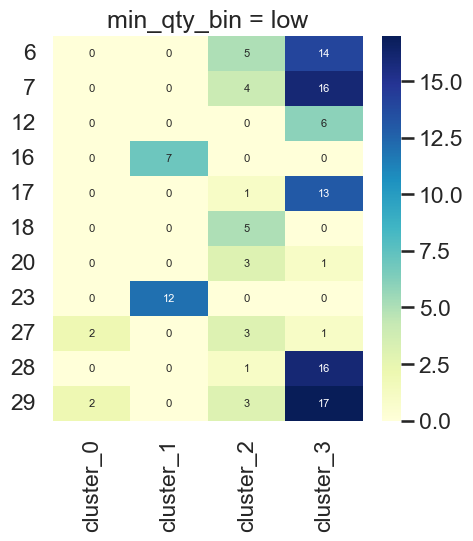

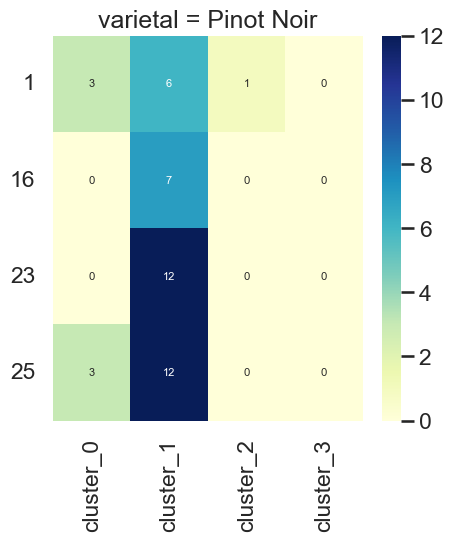

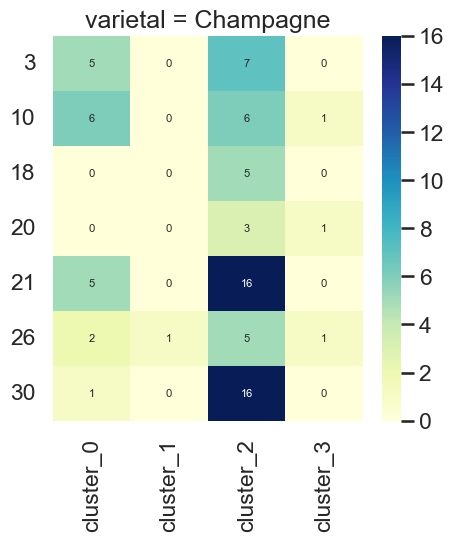

In [13]:
tmp = cluster_offer_df.reset_index().merge(
    df_offers[["min_qty_bin", "discount_bin", "offer_id", "origin"]]
)

display(tmp.sort_values(["min_qty_bin", "discount_bin"]))

plot_heatmap(tmp[tmp["min_qty_bin"] == "low"], title="min_qty_bin = low")
plot_heatmap(tmp[tmp["varietal"] == "Pinot Noir"], title="varietal = Pinot Noir")
plot_heatmap(tmp[tmp["varietal"] == "Champagne"], title="varietal = Champagne")

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.


<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>


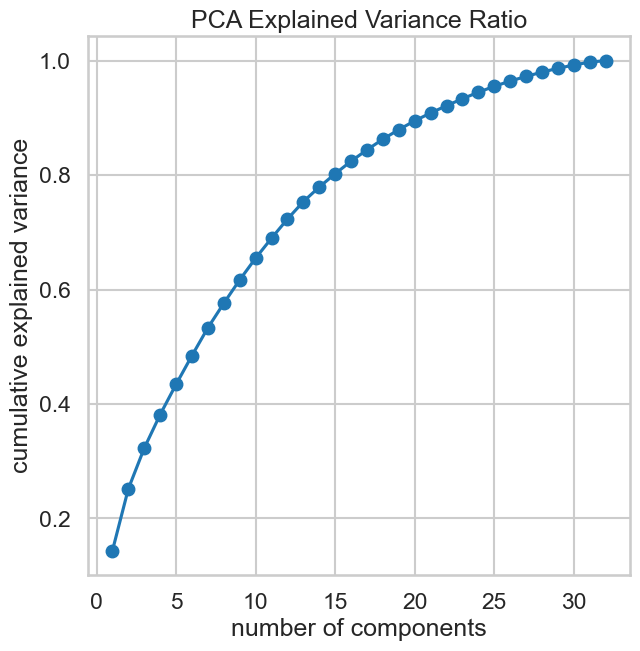

In [14]:
# your turn
# Initialize a new PCA model with a default number of components.


pca = PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(7, 7))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_.cumsum(),
    "-o",
)
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.title("PCA Explained Variance Ratio")

plt.show()

This curve looks pretty smooth. I am not sure where the elbow point is. I would say that the optimal number of dimensions is 2 or 3.


## 4. Conclusions and next steps

### 4a. Conclusions

What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call.


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn.

- **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity.

- **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

- **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is _divisive_, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

- **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is _agglomerative_. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

- **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.


### Clustering Algorithms in Scikit-learn

<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>
